# Analysis of Retail Data Insights With PySpark

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType

In [2]:
spark = SparkSession.builder.appName("retail-analysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/09 23:08:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading Data and Creating DataFrame Using PySpark

In [3]:
# define the schema for customer dataset
customers_schema = StructType([
    StructField('customer_id',       IntegerType(), nullable=True),
    StructField('customer_fname',    StringType(), nullable=True),
    StructField('customer_lname',    StringType(), nullable=True),
    StructField('customer_email',    StringType(), nullable=True),
    StructField('customer_password', StringType(), nullable=True),
    StructField('customer_street',   StringType(), nullable=True),
    StructField('customer_city',     StringType(), nullable=True),
    StructField('customer_state',    StringType(), nullable=True),
    StructField('customer_zipcode',  StringType(), nullable=True)])

In [4]:
# define the schema for product dataset
products_schema = StructType([
    StructField('product_id',          IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name',        StringType() , nullable=True),
    StructField('product_description', StringType() , nullable=True),
    StructField('product_price',       FloatType()  , nullable=True),
    StructField('product_image',       StringType() , nullable=True)])

In [5]:
# define schema for categories
categories_schema = StructType([
    StructField('category_id',            IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name',          StringType(), nullable=True)])

In [6]:
# define the schema for orders
orders_schema = StructType([
    StructField('order_id',          IntegerType(), nullable=True),
    StructField('order_date',        StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status',      StringType(), nullable=True)])

In [7]:
# define schema for department
departments_schema = StructType([
    StructField('department_id',   IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True)])

In [8]:
# define the schema for order items
order_items_schema = StructType([
    StructField('order_item_id',            IntegerType(), nullable=True),
    StructField('order_item_order_id',      IntegerType(), nullable=True),
    StructField('order_item_product_id',    IntegerType(), nullable=True),
    StructField('order_item_quantity',      IntegerType(), nullable=True),
    StructField('order_item_subtotal',      FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)])

In [9]:
# file location and type of file
file_loc = '/config/workspace/data/'
file_type = 'csv'

In [10]:
customer_data = file_loc + 'customers.csv'
products_data = file_loc + 'products.csv'
categories_data = file_loc + 'categories.csv'
departments_data = file_loc + 'departments.csv'
orders_data = file_loc + 'orders.csv'
order_items_data = file_loc + 'order_items.csv'

In [11]:
# csv options 
first_row_is_header = False
delimiter = ','

In [12]:
# create a dataframe using the above details
customers_df = spark.read.format(file_type) \
        .option("sep", delimiter) \
        .option("header", first_row_is_header) \
        .schema(customers_schema) \
        .load(customer_data)

In [13]:
# create the dataframe
products_df = spark.read.format(file_type) \
        .option("sep", delimiter) \
        .option("header", first_row_is_header) \
        .schema(products_schema) \
        .load(products_data)

In [14]:
# create the dataframe
categories_df = spark.read.format(file_type) \
        .option("sep", delimiter) \
        .option("header", first_row_is_header) \
        .schema(categories_schema) \
        .load(categories_data)

In [15]:
# create the dataframe
orders_df = spark.read.format(file_type) \
  .option("sep", delimiter) \
  .option("header", first_row_is_header) \
  .schema(orders_schema)  \
  .load(orders_data)

In [16]:
# create the dataframe
departments_df = spark.read.format(file_type) \
  .option("sep", delimiter) \
  .option("header", first_row_is_header) \
  .schema(departments_schema) \
  .load(departments_data)

In [17]:
# create the dataframe
order_items_df = spark.read.format(file_type) \
  .option("sep", delimiter) \
  .option("header", first_row_is_header) \
  .schema(order_items_schema) \
  .load(order_items_data)

In [18]:
customers_df.show(2)

+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          1|       Richard|     Hernandez|     XXXXXXXXX|        XXXXXXXXX|  6303 Heather Plaza|  Brownsville|            TX|           78521|
|          2|          Mary|       Barrett|     XXXXXXXXX|        XXXXXXXXX|9526 Noble Embers...|    Littleton|            CO|           80126|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
only showing top 2 rows



# Solving Problem Statements of Retailers using PySpark

Question 01: Find the total number of orders.

In [19]:
total_orders = orders_df.count()
total_orders

68883

Question 02: Find the average revenue per order.

In [20]:
from pyspark.sql import functions as F

In [21]:
avg_revenue = orders_df.join(order_items_df, F.col("order_id") == F.col("order_item_order_id")) \
        .select('order_item_subtotal', 'order_item_order_id') \
        .select((F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id')).alias('avg_rev_per_order'))

In [22]:
avg_revenue.show()

+-----------------+
|avg_rev_per_order|
+-----------------+
|597.6322996016944|
+-----------------+



Question 03: Find the average revenue per day.

In [23]:
avg_rev_per_day = orders_df.join(order_items_df, F.col("order_id") == F.col("order_item_order_id")) \
                  .select('order_date', 'order_item_subtotal', 'order_item_order_id') \
                  .groupBy('order_date') \
                  .agg((F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id')).alias('avg_rev_per_day')) \
                  .orderBy('order_date')


In [33]:
avg_rev_per_day.show(10)

+--------------------+-----------------+
|          order_date|  avg_rev_per_day|
+--------------------+-----------------+
|2013-07-25 00:00:...|587.5330286848134|
|2013-07-26 00:00:...|585.9234878147109|
|2013-07-27 00:00:...|577.5676682063512|
|2013-07-28 00:00:...|551.4119109020958|
|2013-07-29 00:00:...|635.5883909684641|
|2013-07-30 00:00:...|564.5363838698838|
|2013-07-31 00:00:...|630.9955146643533|
|2013-08-01 00:00:...|608.4982189502356|
|2013-08-02 00:00:...|587.8871075517388|
|2013-08-03 00:00:...|599.1628419048382|
+--------------------+-----------------+
only showing top 10 rows



Question 4: Find the average revenue per month.

In [37]:
avg_revenue_per_month = orders_df.join(order_items_df, F.col("order_id") == F.col("order_item_order_id")) \
                      .select('order_date', 'order_item_subtotal', 'order_item_order_id') \
                      .withColumn("date", F.to_date(F.col("order_date").cast("timestamp"))) \
                      .withColumn("month", F.month(F.col("date")))\
                      .withColumn("year", F.year(F.col("date")))\
                      .groupBy('month', 'year') \
                      .agg(F.avg('order_item_subtotal').alias('avg_rev_per_month')) \
                      .orderBy('month')

In [38]:
avg_revenue_per_month.show()

+-----+----+------------------+
|month|year| avg_rev_per_month|
+-----+----+------------------+
|    1|2014| 199.4031819907084|
|    2|2014|197.99513431082633|
|    3|2014| 199.4768129569396|
|    4|2014|197.84314083932082|
|    5|2014|200.16564445417947|
|    6|2014|203.19154387871515|
|    7|2014|198.73016375184736|
|    7|2013|200.15236972658087|
|    8|2013|198.25194523225554|
|    9|2013|199.70922326100543|
|   10|2013|198.59266499428136|
|   11|2013| 199.2238976529843|
|   12|2013| 199.1285441948526|
+-----+----+------------------+



Question 5:  Which departments have the best performance?

In [56]:
top_perform_dept = orders_df.filter((F.col("order_status") != 'CANCELED') & (F.col("order_status") != 'SUSPECTED_FRAUD')) \
      .join(order_items_df, F.col("order_id") == F.col("order_item_order_id"), how='inner') \
      .join(products_df, F.col("order_item_product_id") == F.col("product_id"), how='inner') \
      .join(categories_df, F.col("product_category_id") == F.col("category_id"), how='inner') \
      .join(departments_df, F.col("category_department_id") == F.col("department_id"), how='inner') \
      .select('department_name', F.year(F.col("order_date")).alias('order_year'), 'order_item_subtotal') \
      .groupBy(F.col("department_name"), 'order_year') \
      .agg(F.sum(F.col("order_item_subtotal")).alias('total_revenue')) \
      .orderBy(F.col('total_revenue').desc()) 

In [57]:
top_perform_dept.show()

+---------------+----------+------------------+
|department_name|order_year|     total_revenue|
+---------------+----------+------------------+
|       Fan Shop|      2014|  9095735.77280426|
|       Fan Shop|      2013| 7290831.879999161|
|        Apparel|      2014| 3917585.841217041|
|        Apparel|      2013|3090985.6535224915|
|           Golf|      2014|2440585.2815055847|
|       Footwear|      2014| 2122339.649032593|
|           Golf|      2013| 1967396.959728241|
|       Footwear|      2013|1711492.5186824799|
|       Outdoors|      2014| 532437.6709976196|
|       Outdoors|      2013| 420317.9507675171|
|        Fitness|      2014| 150509.1409931183|
|        Fitness|      2013|119526.58082199097|
+---------------+----------+------------------+



Question 6: What is the most expensive item in the catalog?

In [60]:
max_pt = products_df.select(F.max('product_price')).collect()[0][0]
max_pt

1999.989990234375

In [62]:
most_expns_product_df = products_df.select('product_id', 'product_category_id', 'product_name', 'product_price') \
                .filter(F.col('product_price') == max_pt)

In [63]:
most_expns_product_df.show()

+----------+-------------------+-------------------+-------------+
|product_id|product_category_id|       product_name|product_price|
+----------+-------------------+-------------------+-------------+
|       208|                 10|SOLE E35 Elliptical|      1999.99|
+----------+-------------------+-------------------+-------------+



Question 07: Which products have generated the most revenue?

In [65]:
highest_grossing_item = order_items_df.select('order_item_product_id', 'order_item_subtotal') \
     .groupBy('order_item_product_id') \
     .agg(F.sum('order_item_subtotal').alias('product_revenue')) \
     .orderBy('product_revenue', ascending=False) \
     .limit(1) \
     .join(products_df, F.col("order_item_product_id") == F.col("product_id"), how='inner') \
     .select('product_id', 'product_category_id', 'product_name', 'product_revenue')

In [66]:
highest_grossing_item.show()

+----------+-------------------+--------------------+-----------------+
|product_id|product_category_id|        product_name|  product_revenue|
+----------+-------------------+--------------------+-----------------+
|      1004|                 45|Field & Stream Sp...|6929653.690338135|
+----------+-------------------+--------------------+-----------------+



Question 08: What are the top-ordered categories in the retail data?

In [68]:
popular_category_df = order_items_df.join(products_df, F.col("order_item_product_id") ==  F.col("product_id"), how='inner') \
                 .join(categories_df, F.col("category_id") == F.col("product_category_id"), how='inner') \
                 .groupBy('category_name') \
                 .agg(F.sum('order_item_quantity').alias('order_count')) \
                 .orderBy('order_count', ascending=False) \
                 .limit(10)

In [69]:
popular_category_df.show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      73734|
|     Women's Apparel|      62956|
|Indoor/Outdoor Games|      57803|
|    Cardio Equipment|      37587|
|       Shop By Sport|      32726|
|      Men's Footwear|      22246|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|         Electronics|       9436|
+--------------------+-----------+



In [98]:
import pandas
import matplotlib as plt

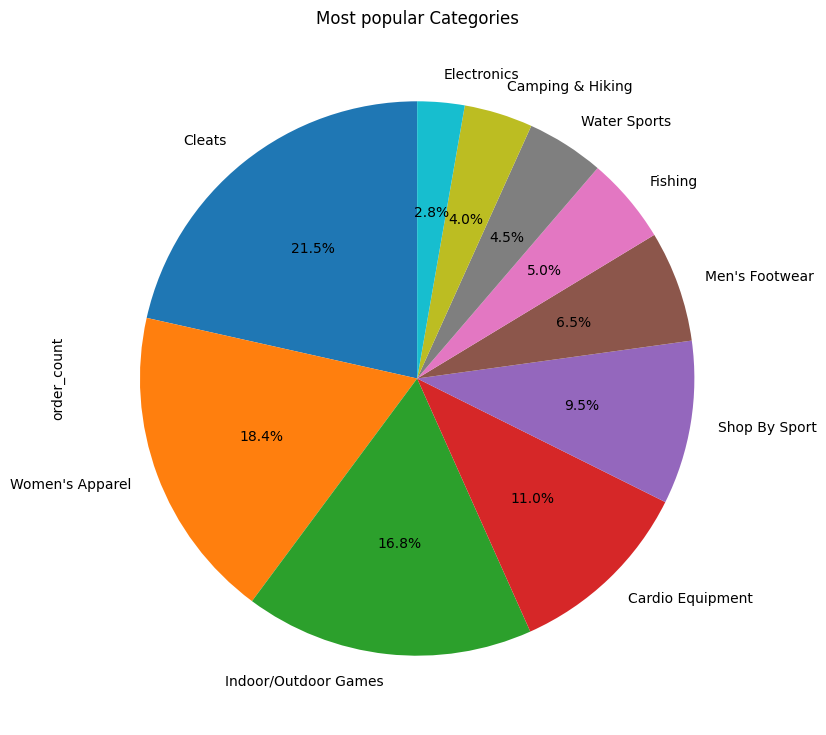

In [84]:
# convert it in pandas dataframe
pop_cat = popular_category_df.toPandas()
# create the pie-chart
pop_cat.plot(kind='pie', y = 'order_count', autopct='%1.1f%%', startangle=90, labels=pop_cat['category_name'], legend=False, title='Most popular Categories', figsize=(9, 9));

Question 09: Find the count of orders based on their status.

In [87]:
orders_by_status = orders_df.groupBy(F.col("order_status")) \
                .agg(F.count(F.col("order_status")).alias("total_status"))

orders_by_status.show()

+---------------+------------+
|   order_status|total_status|
+---------------+------------+
|PENDING_PAYMENT|       15030|
|       COMPLETE|       22899|
|        ON_HOLD|        3798|
| PAYMENT_REVIEW|         729|
|     PROCESSING|        8275|
|         CLOSED|        7556|
|SUSPECTED_FRAUD|        1558|
|        PENDING|        7610|
|       CANCELED|        1428|
+---------------+------------+



In [96]:
order_stat = orders_by_status.toPandas()

In [97]:
import seaborn as sns

Text(0.5, 1.0, 'Number of Orders By Status')

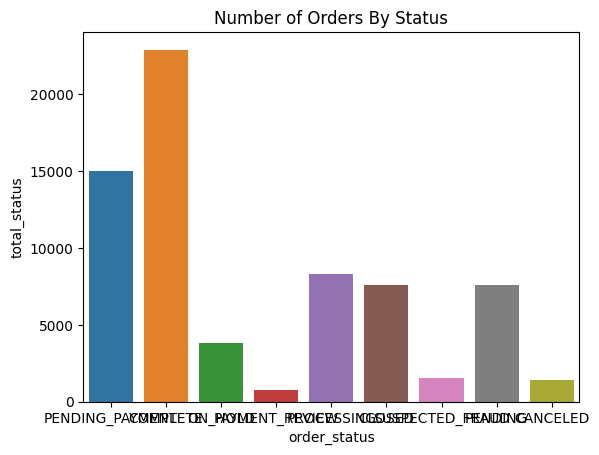

In [102]:
g = sns.barplot(x='order_status', y='total_status', data=order_stat)
g.set_title('Number of Orders By Status')

Question 10: Find all orders whose status is CANCELED, and the order amount is more than $1000.

In [105]:
cancelled_orders = orders_df.filter(F.col('order_status') == 'CANCELED') \
                 .join(order_items_df, F.col("order_id") == F.col("order_item_order_id")) \
                 .groupBy("order_id", "order_date", "order_customer_id", "order_status") \
                 .agg(F.sum('order_item_subtotal').alias('order_total')) \
                 .filter(F.col('order_total') >= 1000) \
                 .orderBy('order_id')

In [106]:
cancelled_orders.show()

+--------+--------------------+-----------------+------------+------------------+
|order_id|          order_date|order_customer_id|order_status|       order_total|
+--------+--------------------+-----------------+------------+------------------+
|     753|2013-07-29 00:00:...|             5094|    CANCELED|           1129.75|
|    2012|2013-08-04 00:00:...|             5165|    CANCELED|1499.8600311279297|
|    2144|2013-08-05 00:00:...|             7932|    CANCELED| 1099.900032043457|
|    2189|2013-08-06 00:00:...|             6829|    CANCELED|1029.9400253295898|
|    2271|2013-08-06 00:00:...|             7603|    CANCELED|1229.9300231933594|
|    2754|2013-08-09 00:00:...|             8946|    CANCELED|1109.9500274658203|
|    3551|2013-08-14 00:00:...|             5363|    CANCELED|1299.8700408935547|
|    4354|2013-08-20 00:00:...|             7268|    CANCELED|1047.9000244140625|
|    4801|2013-08-23 00:00:...|            11630|    CANCELED|1016.9500217437744|
|    5331|2013-0

Question 11: Find all customers who made more than five orders in August 2013.

In [108]:
order_more_than_five = orders_df.filter((F.col('order_status') != 'CANCELED') & (F.col('order_status') != 'SUSPECTED_FRAUD')) \
                      .filter((F.year('order_date') == 2013) & (F.month('order_date') == 8)) \
                      .join(order_items_df, F.col("order_id") == F.col("order_item_order_id"), how='inner') \
                      .join(customers_df, F.col("order_customer_id") == F.col("customer_id"), how='inner') \
                      .select('customer_id', 'customer_fname', 'customer_lname', 'order_id') \
                      .groupBy('customer_id', 'customer_fname', 'customer_lname') \
                      .agg(F.count('order_id').alias('order_count')) \
                      .where(F.col('order_count') > 5) \
                      .orderBy(F.col('order_count'), F.col('customer_id'), ascending=[0, 1])

In [109]:
order_more_than_five.show()

+-----------+--------------+--------------+-----------+
|customer_id|customer_fname|customer_lname|order_count|
+-----------+--------------+--------------+-----------+
|        791|          Mary|         Smith|         15|
|       5047|       Shirley|     Whitehead|         14|
|       5477|          Mary|         Smith|         14|
|       6088|          Mary|        Brooks|         14|
|       9371|          Mary|     Patterson|         14|
|       3295|         Maria|        Joseph|         13|
|       3536|          Mary|        Tanner|         13|
|       4582|         Brian|         House|         13|
|       5865|         David|     Middleton|         13|
|       8069|       Tiffany|      Mcdaniel|         13|
|       9575|          John|      Richards|         13|
|       5327|          Mary|       Mcbride|         12|
|       5992|          Mary|         Cross|         12|
|       9494|        Robert|       Gilmore|         12|
|       9657|           Roy|      Williams|     